In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Charger le fichier CSV exporté
df = pd.read_csv("comptage-voyageurs-trains-transilien.csv", sep=';')

# Afficher les premières lignes
print(df.head())

                Nom Gare  Code Gare Type jour        Date  Annee Ligne Axe  \
0                  ABLON   87545269       SAM  2017-04-22   2017     C   C   
1                  ABLON   87545269       DIM  2017-04-23   2017     C   C   
2                  ABLON   87545269       JOB  2017-04-25   2017     C   C   
3                  ABLON   87545269       JOB  2017-04-25   2017     C   C   
4  ACHERES-GRAND-CORMIER   87386052       SAM  2022-11-19   2022     A   A   

  Tranche horaire  Somme de Montants  
0        Avant 6h                 26  
1        Avant 6h                  2  
2        Avant 6h                 73  
3     De 6h à 10h               1288  
4    De 10h à 16h                 79  


#### Data cleaning

In [3]:
# Conversion des dates et nettoyage
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(subset=['Date'], inplace=True)

df

,Nom Gare,Code Gare,Type jour,Date,Annee,Ligne,Axe,Tranche horaire,Somme de Montants
0,ABLON,87545269,SAM,2017-04-22,2017,C,C,Avant 6h,26
1,ABLON,87545269,DIM,2017-04-23,2017,C,C,Avant 6h,2
2,ABLON,87545269,JOB,2017-04-25,2017,C,C,Avant 6h,73
3,ABLON,87545269,JOB,2017-04-25,2017,C,C,De 6h à 10h,1288
4,ACHERES-GRAND-CORMIER,87386052,SAM,2022-11-19,2022,A,A,De 10h à 16h,79
...,...,...,...,...,...,...,...,...,...
7417,VULAINES-SUR-SEINE-SAMOREAU,87682443,JOB,2023-11-14,2023,R,R,De 10h à 16h,34
7418,YERRES,87682112,SAM,2024-02-03,2024,D,D,Après 20h,264
7419,YERRES,87682112,SAM,2024-02-03,2024,D,D,De 10h à 16h,1505
7420,YERRES,87682112,DIM,2024-03-03,2024,D,D,De 10h à 16h,926


#### Data exploration

##### Évolution du trafic annuel

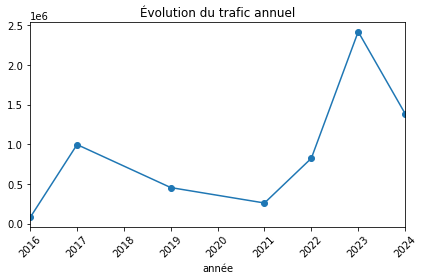

In [4]:
# Extraction de l'année au format période
df['année'] = df['Date'].dt.to_period('Y')

# Agrégation par année
trafic_annuel = df.groupby('année')['Somme de Montants'].sum()

# Tracé du graphique
trafic_annuel.plot(kind='line', marker='o', title='Évolution du trafic annuel')
plt.xticks(rotation=45)  
plt.tight_layout()       
plt.show()

Observation : On observe une baisse de la fréquentation des gares par les voyageurs de 2019 à 2021, on peut supposer que c'est une conséquence de la pandémie du COVID-19. Un pic est en observé en 2023 avec presque 2,5 millions de voyageurs dans les trains Transilien.

##### Top 10 des gares les plus fréquentées

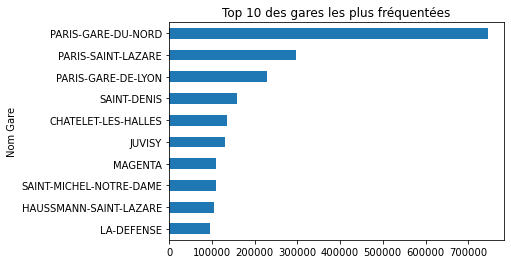

In [5]:
top_gares = df.groupby('Nom Gare')['Somme de Montants'].sum().nlargest(10)
top_gares.plot(kind='barh', title='Top 10 des gares les plus fréquentées')
plt.gca().invert_yaxis()
plt.show()


Observation : La gare "Paris Gare du Nord" est la gare la plus fréquentée (2016-2024) avec plus de 700 000 voyageurs comptabilisés dans les trains.

##### Analyse des jours types

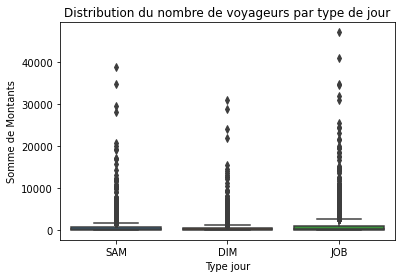

In [6]:
sns.boxplot(x='Type jour', y='Somme de Montants', data=df)
plt.title('Distribution du nombre de voyageurs par type de jour')
plt.show()

La distribution du nombre de voyageurs est assez similaire entre les différents types de jours (SAM = samedi, DIM = dimanche, JOB = jour ouvrable), on observe qu'il y a généralement plus de voyageurs les jours ouvrables que les week-ends.

##### Tableau de bord intéractif

In [7]:
pip install dash

Note: you may need to restart the kernel to use updated packages.


In [8]:
from dash import Dash, html, dcc, Input, Output
import plotly.express as px

# Charger les données
df['Date'] = pd.to_datetime(df['Date'])
df['Année'] = df['Date'].dt.year

# Initialiser l'application
app = Dash(__name__)

# Mise en page du tableau de bord
app.layout = html.Div([
    html.H1("📊 Tableau de bord du réseau Transilien"),
    
    # Filtre par année
    dcc.Dropdown(
        id='filtre_annee',
        options=[{'label': str(annee), 'value': annee} for annee in df['Année'].unique()],
        value=2023,
        multi=False,
        clearable=False
    ),

    # Graphique du trafic par gare
    dcc.Graph(id='graph_trafic'),

    # Indicateurs clés (KPI)
    html.Div(id='indicateurs')
])

# Callback pour mettre à jour les graphiques en fonction du filtre
@app.callback(
    [Output('graph_trafic', 'figure'),
     Output('indicateurs', 'children')],
    [Input('filtre_annee', 'value')]
)
def update_graph(annee):
    data_filtre = df[df['Année'] == annee]
    
    # Graphique du trafic par gare
    fig = px.bar(
        data_filtre.groupby('Nom Gare')['Somme de Montants'].sum().reset_index(),
        x='Somme de Montants',
        y='Nom Gare',
        orientation='h',
        title=f"Trafic par gare en {annee}"
    )

    # Indicateurs clés
    total_trafic = data_filtre['Somme de Montants'].sum()
    top_gare = data_filtre.groupby('Nom Gare')['Somme de Montants'].sum().idxmax()

    indicateurs = html.Div([
        html.P(f"🧑‍🤝‍🧑 Total de voyageurs en {annee} : {total_trafic:,}"),
        html.P(f"🏆 Gare la plus fréquentée : {top_gare}")
    ])

    return fig, indicateurs

# Lancer l'application
if __name__ == '__main__':
    app.run_server(debug=True)


Objectif : L'objectif de ce tableau de bord intéractif est de visualiser le traffic et de faire des analyses comparatives entre différentes gares et périodes.